In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
from PIL import Image

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

### Get the class labels for ImageNet

In [3]:
import json
imagenet_classes = json.load(open('imagenet_classes.json'))
idx2class = [imagenet_classes[k].split(',')[0] for k in imagenet_classes.keys()]
class2idx = {v:i for i,v in enumerate(idx2class)}

### Use VGG16 with pre-trained weights

In [4]:
vgg16 = models.vgg16(pretrained=True)
vgg16.eval()
print(vgg16)

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [5]:
softmax = torch.nn.Softmax()

### Define image transformations to use with VGG-16
unnorm defined to allow to back out of the transformations for debugging purposes

In [6]:
img_transforms = transforms.Compose([transforms.Scale((256, 256), Image.BICUBIC),
                                     transforms.RandomCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
def unnorm(x):
    un_x = 255*(x*0.5+0.5)
    #un_x[un_x > 255] = 255
    #un_x[un_x < 0] = 0
    un_x = un_x.astype(np.uint8)
    return un_x

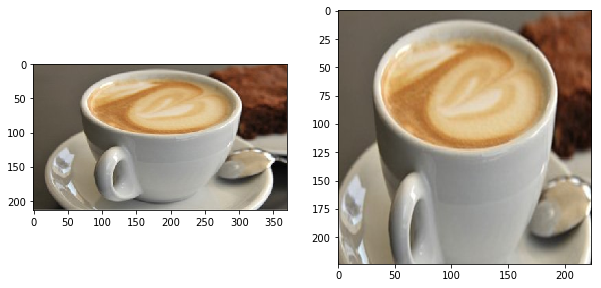

In [7]:
img = Image.open('espresso.png')
img_tensor = img_transforms(img)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.asarray(img))
plt.subplot(1,2,2)
plt.imshow(unnorm(img_tensor.numpy()).transpose(1,2,0))

In [8]:
img_var = torch.autograd.Variable(img_tensor.unsqueeze(0), requires_grad=True)
out = vgg16(img_var)
probs = softmax(out)
cls_idx = np.argmax(out.data.numpy())
print(str(cls_idx) + ":" + idx2class[cls_idx] + ":" + str(out.data.numpy()[0][cls_idx]) + ":" + str(probs.data.numpy()[0][cls_idx]))

967:espresso:21.6739:0.971841


### Create new image based on the gradient of the image using Fast Gradient Sign Method

In [9]:
out[0,class2idx['nematode']].backward()

In [10]:
img_scale_crop = transforms.Compose([transforms.Scale((256, 256), Image.BICUBIC),
                                     transforms.RandomCrop(224)])

443:bib:0.169629


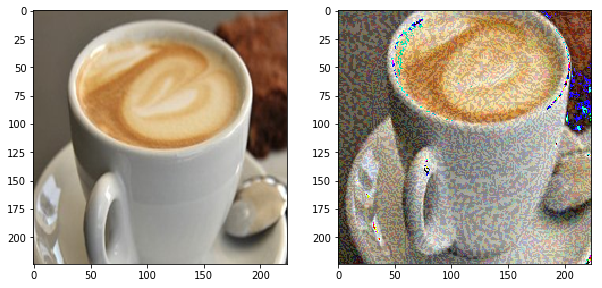

In [11]:
grad_sign = np.sign(img_var.grad.data.numpy()).astype(np.uint8)
epsilon = 20
new_img_array = np.asarray(img_scale_crop(img))+epsilon*grad_sign[0].transpose(1,2,0)
new_img_array[new_img_array>255] = 255
new_img = Image.fromarray(new_img_array)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(unnorm(img_tensor.numpy()).transpose(1,2,0))
plt.subplot(1,2,2)
plt.imshow(np.asarray(new_img))
new_img_tensor = img_transforms(new_img)
new_img_var = torch.autograd.Variable(new_img_tensor.unsqueeze(0), requires_grad=True)
new_out = vgg16(new_img_var)
new_out_np = new_out.data.numpy()
new_probs = softmax(new_out)
new_cls_idx = np.argmax(new_out_np)
print(str(new_cls_idx) + ":" + idx2class[new_cls_idx] + ":" + str(new_probs.data.numpy()[0][new_cls_idx]))

### Iterative change (from CS231n)

In [12]:
learning_rate = 1
img = Image.open('espresso.png')
fake_img_tensor = img_transforms(img)
img_var_fake = torch.autograd.Variable(fake_img_tensor.unsqueeze(0), requires_grad=True)
fake_class_idx = class2idx['nematode']
for i in range(100):
    out_fake = vgg16(img_var_fake)
    _, out_idx = out_fake.data.max(dim=1)
    if out_idx.numpy() == fake_class_idx:
        print('Fake generated in ' + str(i) + ' iterations')
        break
    out_fake[0,fake_class_idx].backward()
    img_var_fake_grad = img_var_fake.grad.data
    img_var_fake.data += learning_rate*img_var_fake_grad/img_var_fake_grad.norm()
    img_var_fake.grad.data.zero_()
probs_fake = softmax(out_fake)
print(str(fake_class_idx) + ":" + idx2class[fake_class_idx] + ":" + str(out_fake.data.numpy()[0][fake_class_idx]) + ":" + str(probs_fake.data.numpy()[0][fake_class_idx]))

Fake generated in 4 iterations
111:nematode:24.9529:0.993393


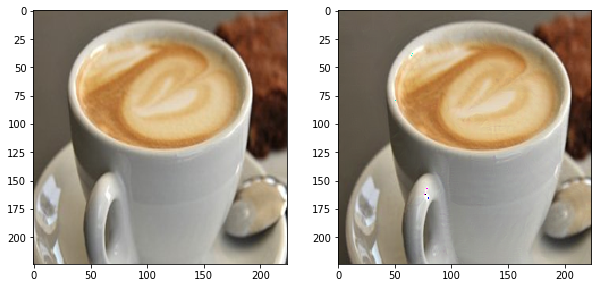

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(unnorm(img_tensor.numpy()).transpose(1,2,0))
plt.subplot(1,2,2)
plt.imshow(unnorm(img_var_fake.data.numpy()[0]).transpose(1,2,0))